# Train a pole cart balancer 
This is following the book "Hands on Machine Learning..."

## Open AI environment

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import gym

In [3]:
env = gym.make('CartPole-v0')

[2018-02-01 05:42:36,150] Making new env: CartPole-v0


In [4]:
import time

def show_state(raw_image, step=0, info="", delay=0.):
    """Render an image of the environment"""
    plt.figure(3)
    plt.clf()
    plt.imshow(raw_image)
    plt.title(f"{env.spec.id} | Step: {step} {info}")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(delay)

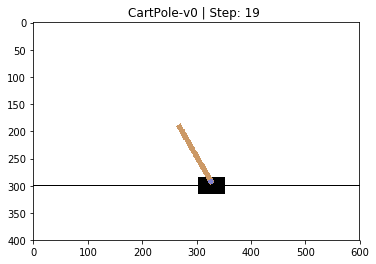

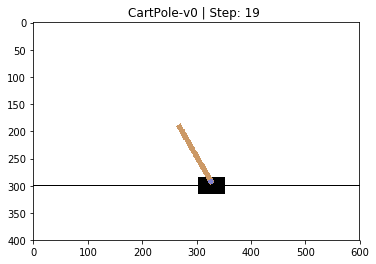

In [5]:
env.reset()

for step in range(20):
    env.step(env.action_space.sample())
    show_state(env.render(mode='rgb_array'), step=step)

## The Neural Net

In [6]:
import numpy as np

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, variance_scaling_initializer

In [8]:
# NN parameters
n_inputs = 4
n_hidden_width = 4
n_outputs = 1

In [9]:
# The NN
X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden_layer = fully_connected(inputs=X, 
                              num_outputs=n_hidden_width,
                              activation_fn=tf.nn.elu,
                              weights_initializer=variance_scaling_initializer())

logits = fully_connected(inputs=hidden_layer,
                        num_outputs=n_outputs,
                        activation_fn=None,
                        weights_initializer=variance_scaling_initializer())

outputs = tf.nn.sigmoid(logits)


In [10]:
# Action from policy
policy_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(logits=tf.log(policy_left_and_right), num_samples=1)

## Training - Gradient Descent Setup

In [11]:
# Policy NN Gradient Descent
learning_rate = 0.01

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_nn_parameters = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, para in grads_and_nn_parameters]
gradient_placeholders = []
grads_and_parameters_feed = []

for grad, parameter in grads_and_nn_parameters:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    
    gradient_placeholders.append(gradient_placeholder)
    
    grads_and_parameters_feed.append((gradient_placeholder, parameter))

training_op = optimizer.apply_gradients(grads_and_parameters_feed)

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Rewards Manipulation Functions

In [13]:
def discount_rewards(rewards, discount_rate):
    """Discount future rewards at past time steps by discount rate"""
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + discount_rate*cumulative_rewards
        discounted_rewards[step] = cumulative_rewards
        
    return discounted_rewards

In [14]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [15]:
def discount_and_normalize_rewards(sets_of_rewards, discount_rate):
    all_discount_rewards = [discount_rewards(rewards, discount_rate) for rewards in sets_of_rewards]
    
    flat_rewards = np.concatenate(all_discount_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discount_rewards]

In [16]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

## Main Training Loop

In [17]:
# Loop parameters
n_iterations = range(250)        # number of training iterations
n_max_steps = range(1000)        # maximum number of steps per game
n_games_per_update = range(10)   # train policy net every n games
save_every = 10                  # save model every n full iterations
discount_rate = 0.9

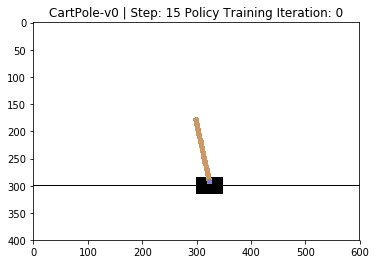

AssertionError: 2 (<class 'numpy.int64'>) invalid

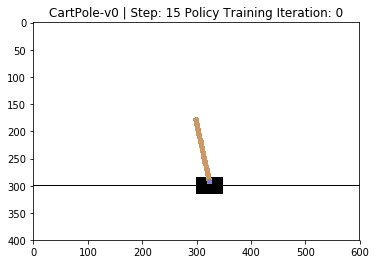

In [18]:
# The tensorflow session

with tf.Session() as session:
    init.run()
    
    # the main loop
    for iteration in n_iterations:
        all_rewards = []                         # raw reward sequences for batch of games
        all_gradients = []                       # gradients saved at each step of each game
        snapshots = []                           # rendered environment snapshots
        
        # create update batch
        for game in n_games_per_update:
            current_rewards = []                 # raw rewards for a game
            current_gradients = []               # gradients for a game
            
            # play the game
            obs = env.reset()
            for step in n_max_steps:
                action_val, gradient_val = session.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                (_, _, angle, angle_prime), reward, done, info = env.step(action_val[0][0])
                
                current_rewards.append(np.exp(-1/(angle*angle_prime)))
                current_gradients.append(gradient_val)
                if game == 0 and iteration % save_every == 0:
                    snapshots.append(env.render(mode='rgb_array'))
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        
        # update policy net from batch via gradient descent
        feed_dict = {}
        for parameter_idx, grad_placeholder in enumerate(gradient_placeholders):
            reward_gradients = [reward * all_gradients[game_idx][step][parameter_idx]
                               for game_idx, rewards in enumerate(all_rewards)
                               for step, reward in enumerate(rewards)
                               ]
            mean_gradients = np.mean(reward_gradients, axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        session.run(training_op, feed_dict)
        
        if iteration % save_every == 0:
            saver.save(session, 'models/my_cartpole_policy_net.ckpt')
        if snapshots:
            for step, image in enumerate(snapshots):
                show_state(image, 
                           step=step, 
                           info=f'Policy Training Iteration: {iteration}',
                           )
                

In [ ]:
env.reset()

In [ ]:
env.step(1)